# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.6 MB/s eta 0:00:00


Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')
plt.style.use('ggplot')

In [3]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'petroff10',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [4]:
import random
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

In [5]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части.

In [7]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [8]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 20 # 25 показывало чуть худшие accuracy

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

  0%|          | 0/120000 [00:00<?, ?it/s]

Размер словаря: 13403


In [9]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = (
            self.data[idx]['text']
            .lower()
            .translate(str.maketrans('', '', string.punctuation))
        )
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]],
    pad_id=word2ind['<pad>'],
    max_len=256
    ) -> torch.Tensor:

    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [10]:
train_dataset = WordDataset(dataset['train'])

idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size, num_workers=0)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size, num_workers=0)

## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

In [11]:
@torch.no_grad()
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []

    for batch in eval_dataloader:
        logits = model(batch['input_ids'])
        predictions.append(logits.argmax(dim=1))
        target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

In [12]:
def metrics_plotting(losses_type, acc_type):
    """
    Функция для визуализации loss и accuracy
    """
    color=['green', 'black']
    names = losses_type
    fig, axes = plt.subplots(1, 2, figsize=(18, 5))
    for i, name in enumerate(names):

        axes[0].plot(np.arange(len(losses_type[name][1:])), losses_type[name][1:], color=color[i], label=name)
        axes[0].set_title('Losses')
        axes[0].set_xlabel('epoch')
        axes[0].legend()
        axes[1].plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color[i], label=name)
        axes[1].set_title('Accuracy')
        axes[1].set_xlabel('num acc')
        axes[1].legend()
        print(f"Лучшая accuracy для подхода {name}: {max(acc_type[name]):.4f}")

    plt.show()

In [13]:
def train(model, criterion, optimizer, num_epoch=5):
    """

    """
    eval_steps = len(train_dataloader) // 2

    losses_type = {}
    acc_type = {}

    for aggregation_type in ['max', 'mean']:
        print(f"Starting training for {aggregation_type}")
        losses = []
        acc = []

        model.aggregation_type = aggregation_type

        for epoch in tqdm(range(num_epoch)):
            epoch_losses = []
            model.train()
            for i, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader), leave=False):
                optimizer.zero_grad()
                logits = model(batch['input_ids'])
                loss = criterion(logits, batch['label'])
                loss.backward()
                optimizer.step()

                epoch_losses.append(loss.item())

                if i % eval_steps == 0:
                    model.eval()
                    acc.append(evaluate(model, eval_dataloader))
                    model.train()

            losses.append(sum(epoch_losses) / len(epoch_losses))

        losses_type[aggregation_type] = losses
        acc_type[aggregation_type] = acc

    return losses_type, acc_type

**Запуск базовой модели с семинара на новом датасете (1 балл)**

In [14]:
class CharLM(nn.Module):
    def __init__(self,
                 hidden_dim: int,
                 vocab_size: int,
                 num_layers: int = 1,
                 num_classes: int = 4,
                 aggregation_type: str = ''
                 ):
        super().__init__()
        # матрица эмбеддингов, которая в каждой строке хранит вектор слова. индекс строки соотв-т индексу слова в словаре.
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)                    # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)                            # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0]                           #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1)                             #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))    # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))          # [batch_size, num_classes]

        return prediction

In [15]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [16]:
# Запускаю обучение базовой модели
losses_type, acc_type = train(model, criterion, optimizer)

Starting training for max


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

Лучшая accuracy для подхода max: 0.9042
Лучшая accuracy для подхода mean: 0.9110


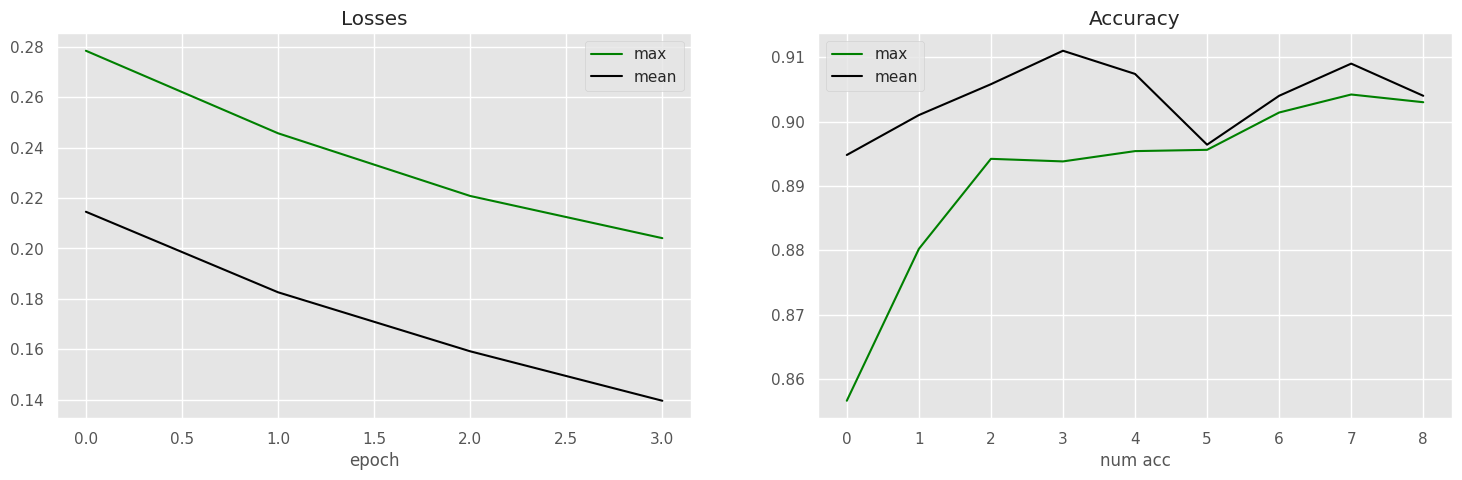

In [17]:
# визуализация для бейзлайновой модели
metrics_plotting(losses_type, acc_type)

Baseline у меня теперь есть.

думаю дальше действовать следующим образом:
* сделаю несколько экспериментов, меняя базовую модель;
* выберу модель, которая показала наибольшую accuracy и буду подбирать к ней гиперпараметры, в попытке ещё увеличить метрику.

**Эксперименты**

**Эксперимент 1.**

1. Увеличение количества рекуррентных слоев модели до 2х

Starting training for max


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

Лучшая accuracy для подхода max: 0.9096
Лучшая accuracy для подхода mean: 0.9098


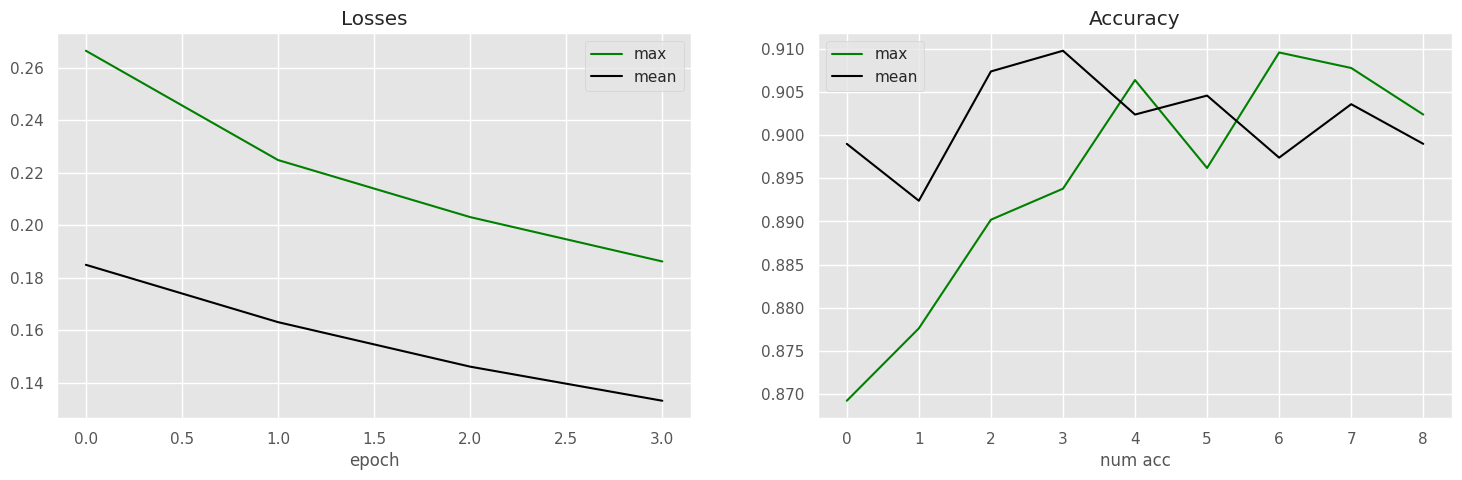

In [18]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab), num_layers=2).to(device)
optimizer = torch.optim.Adam(model.parameters())
# Запускаю обучение
losses_type, acc_type = train(model, criterion, optimizer)
# Визуализация
metrics_plotting(losses_type, acc_type)

**Эксперимент 2.**

1. Строю и тестирую GRU модель

In [19]:
class GRUmodel(nn.Module):
    def __init__(self,
                 hidden_dim: int,
                 vocab_size: int,
                 num_classes: int = 4,
                 num_layers: int = 1,
                 aggregation_type: str = ''
                 ):
        super().__init__()
        # Получаем эмбеддинги
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=hidden_dim)
        # слой GRU
        self.gru = nn.GRU(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        # Полносвязный слой для преобразования в предсказания
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)                    # [batch_size, seq_len, hidden_dim]
        output, _ = self.gru(embeddings)                            # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0]                           #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1)                             #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))    # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))          # [batch_size, num_classes]

        return prediction

Starting training for max


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

Лучшая accuracy для подхода max: 0.9130
Лучшая accuracy для подхода mean: 0.9072


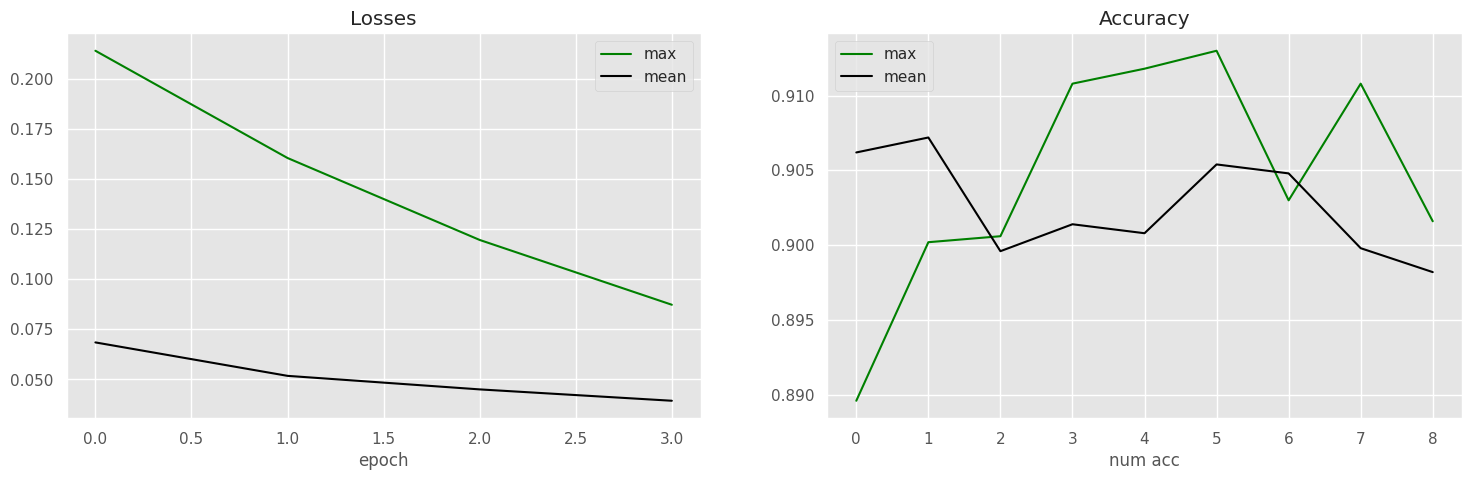

In [20]:
#
model = GRUmodel(hidden_dim=256, vocab_size=len(vocab)).to(device)
optimizer = torch.optim.Adam(model.parameters())
# Обучение
losses_type, acc_type = train(model, criterion, optimizer)
# Визуализация для модели GRU
metrics_plotting(losses_type, acc_type)

**Эксперимент 3.**
1. Увеличиваю кол-во слоёв GRU до 2х

Starting training for max


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

Лучшая accuracy для подхода max: 0.9152
Лучшая accuracy для подхода mean: 0.9110


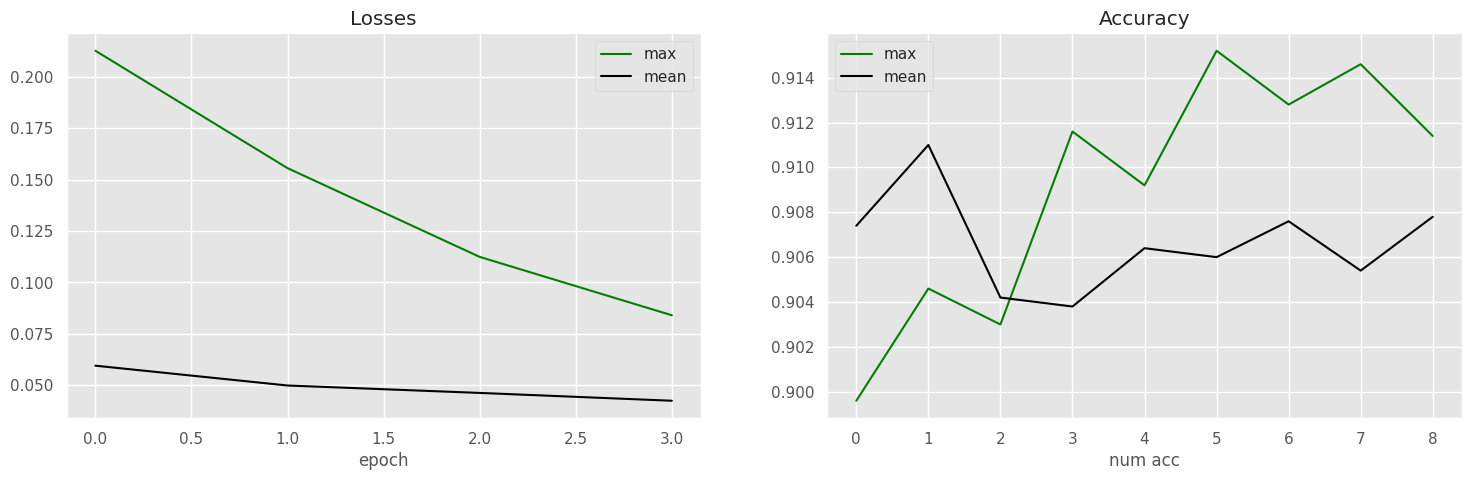

In [21]:
model = GRUmodel(hidden_dim=256, vocab_size=len(vocab), num_layers=2).to(device)
optimizer = torch.optim.Adam(model.parameters())
# обучаю
losses_type, acc_type = train(model, criterion, optimizer)
# Визуализация
metrics_plotting(losses_type, acc_type)

**Эксперимент 4**
1. Буду сразу использовать GRU, тк он показывает результат лучше RNN.
Суть эксперимента: изменение архитектуры после применения GRU. В базовой модели используется агрегация со всех эмбеддингов. Я буду конкатенировать результат агрегации и эмбеддинг с последнего токена.

In [22]:

class GRUmodel_combi(nn.Module):
    def __init__(self,
                 hidden_dim: int,
                 vocab_size: int,
                 num_layers: int = 1,
                 num_classes: int = 4,
                 aggregation_type: str = ''
                 ):
        super().__init__()
        # Матрица эмбеддингов
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=hidden_dim)
        # GRU слой
        self.gru = nn.GRU(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        # Линейные слои
        self.linear = nn.Linear(hidden_dim * 2, hidden_dim)  # Изменено: входной размер hidden_dim * 2, тк будет конкатенация
        self.projection = nn.Linear(hidden_dim, num_classes)

        # Нелинейность и dropout
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        # Тип агрегации
        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        # Эмбеддинги
        embeddings = self.embedding(input_batch)        # [batch_size, seq_len, hidden_dim]
        # Проход через RNN
        output, _ = self.gru(embeddings)                # [batch_size, seq_len, hidden_dim]

        # сохраняю эмбеддинг последнего токена
        last_token_embedding = output[:, -1, :]         # [batch_size, hidden_dim]

        # Агрегация (max или mean)
        if self.aggregation_type == 'max':
            aggregated = output.max(dim=1)[0]           # [batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            aggregated = output.mean(dim=1)             # [batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")


        # Конкатенация агрегированного результата и эмбеддинга последнего токена
        combined = torch.cat([aggregated, last_token_embedding], dim=1)  # [batch_size, hidden_dim * 2]

        # Проход через линейные слои
        output = self.dropout(self.linear(self.non_lin(combined)))       # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))               # [batch_size, num_classes]

        return prediction

Starting training for max


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

Лучшая accuracy для подхода max: 0.9136
Лучшая accuracy для подхода mean: 0.9072


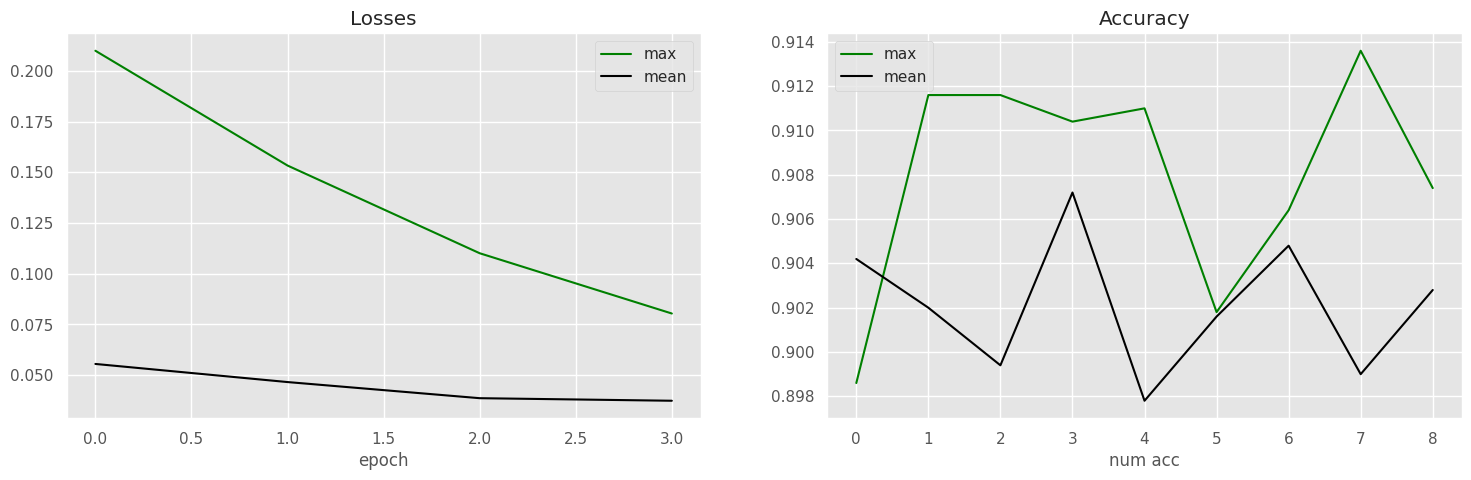

In [23]:
model = GRUmodel_combi(hidden_dim=256, vocab_size=len(vocab)).to(device)
optimizer = torch.optim.Adam(model.parameters())
# Обучение
losses_type, acc_type = train(model, criterion, optimizer)
# Визуализация
metrics_plotting(losses_type, acc_type)

**Эксперимент 5**
1. Меняю гиперпараметры

Starting training for max


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

Лучшая accuracy для подхода max: 0.9216
Лучшая accuracy для подхода mean: 0.9114


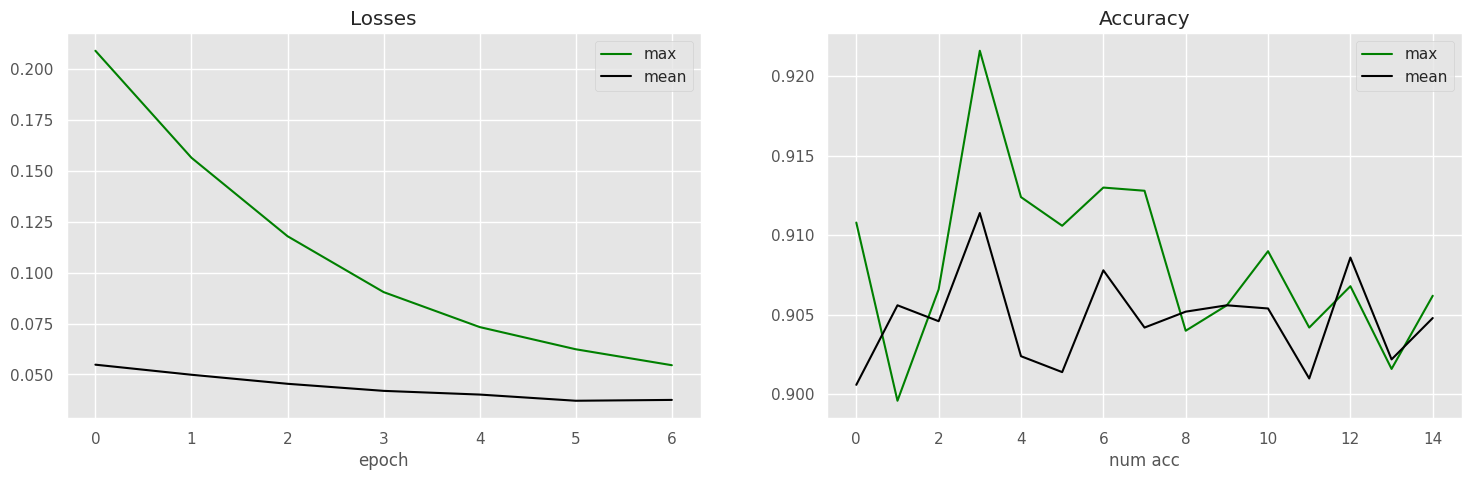

In [26]:
model = GRUmodel(hidden_dim=512, vocab_size=len(vocab)).to(device)
optimizer = torch.optim.AdamW(model.parameters())

# Обучение
losses_type, acc_type = train(model, criterion, optimizer, num_epoch=8)
# Визуализация
metrics_plotting(losses_type, acc_type)

**Эксперимент 6**
1. Изменение архитектуры и гиперпараметров.
   
   модель GRU, функция активации LeakyReLU, Dropout 0.4, BatchNorm, weight_decay=1e-5, hidden_dim=512 и 6 эпох - 0.9222 acc

In [18]:
class GRUmodel_2(nn.Module):
    def __init__(self,
                 hidden_dim: int,
                 vocab_size: int,
                 num_classes: int = 4,
                 num_layers: int = 1,
                 aggregation_type: str = ''
                 ):
        super().__init__()

        # Получаем эмбеддинги
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=hidden_dim)
        # слой GRU
        self.gru = nn.GRU(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, bias=False)
        self.bn = nn.BatchNorm1d(hidden_dim)
        # Полносвязный слой
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        # Полносвязный слой для преобразования в предсказания
        self.projection = nn.Linear(hidden_dim, num_classes)

        # функция активации и Dropout
        self.act = nn.LeakyReLU()
        self.dropout = nn.Dropout(p=0.4)

        # тип аггрегации
        self.aggregation_type = aggregation_type


    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)             # [batch_size, seq_len, hidden_dim]
        output, _ = self.gru(embeddings)                     # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0]                    #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1)                      #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")


        output = self.act(output)
        output = self.linear(output)                         # [batch_size, hidden_dim]
        # output = self.bn(output)
        output = self.act(output)
        output = self.dropout(output)
        prediction = self.projection(output)                 # [batch_size, num_classes]

        return prediction

In [ ]:
model = GRUmodel_2(hidden_dim=512, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-5)

# Обучение
losses_type, acc_type = train(model, criterion, optimizer, num_epoch=5)
# Визуализация
metrics_plotting(losses_type, acc_type)

Starting training for max


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

### Оформление отчета (2 балла)

* Укажите, какие из экспериментов принесли улучшение, а какие - нет.

  1. Увеличение количества рекуррентных слоев модели до 2х - принесло минимальное улучшение
  2. GRU модель - больше всего увеличила accuracy (на 1%)
  3. Увеличение кол-ва слоёв GRU до 2х - не привело к дальнейшему увеличению метрики
  4. Конкатенация результата агрегации и эмбеддинга с последнего токена в GRU модели - тоже не дало дальнейшего увеличения accuracy
  5. Изменение гиперпараметров модели GRU - показало accuracy чуть меньше чем базовая модель GRU из пункта 2.
  6. Изменение архитектуры и гиперпараметров - на 0.5% увеличило accuracy GRU из пункта 2.


* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная?
 1. Сходимость была стабильной на протяжении всех эпох и во всех экспериментах
     
     
* Укажите, какая модель получилась оптимальной.
 1. Это был последний 6й эксперимент: модель GRU, функция активации LeakyReLU, Dropout 0.4, BatchNorm, weight_decay=1e-5, hidden_dim=512 и 6 эпох - 0.9222 acc


Была ещё задумка поменять counter_threshold для наполнения корпуса слов, а также хотел поменять batch_size

### Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.